In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np

import pandas as pd

import os
from utils.feature_engineering import *
from utils.preprocessing import *
import gc
import tqdm
from utils.analysis import *
import matplotlib.pyplot as plt

PATH_DATASET = '../Dataset/'
#PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

# loading dataset

In [2]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

df_sales['DATE']= pd.to_datetime(df_sales['DATE'])

df_submission_sample['DATE']= pd.to_datetime(df_submission_sample['DATE'])

N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]


In [3]:
df_submission_sample['DATE'].min(),df_submission_sample['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [4]:
sample_sales_unique_filename = os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl')

if os.path.exists(sample_sales_unique_filename):
    print('already exist !')
    sample_sales_unique = pd.read_pickle(sample_sales_unique_filename)
else:
    print('processing ..')
    sample_sales_unique  = get_sample_sales_unique(df_sales,df_submission_sample)
    print('saving ..')
    sample_sales_unique.to_pickle(os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl'))
    print('completed')

already exist !


In [5]:
sample_sales_unique.head(2)

,S100,I100,C100,C101,DATE
0,0,0,12,76,2017-01-08
1,0,0,12,76,2017-01-15


In [6]:
df_auxiliar = sample_sales_unique.merge(df_sales,on=['DATE','S100','I100','C100','C101'],how='left')
df_auxiliar.replace([np.inf, -np.inf,np.nan],0 , inplace=True)
print(df_auxiliar.shape)
df_auxiliar.head(2)

(17920125, 7)


,S100,I100,C100,C101,DATE,QTT,item_id
0,0,0,12,76,2017-01-08,2.0,0_12_76
1,0,0,12,76,2017-01-15,1.0,0_12_76


In [7]:
df_auxiliar['DATE'].min(),df_auxiliar['DATE'].max()

(Timestamp('2017-01-08 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [8]:
df_auxiliar[df_auxiliar['DATE']>'2021-08-01'].head(2)

,S100,I100,C100,C101,DATE,QTT,item_id
239,0,0,12,76,2021-08-08,0.0,0
240,0,0,12,76,2021-08-15,0.0,0


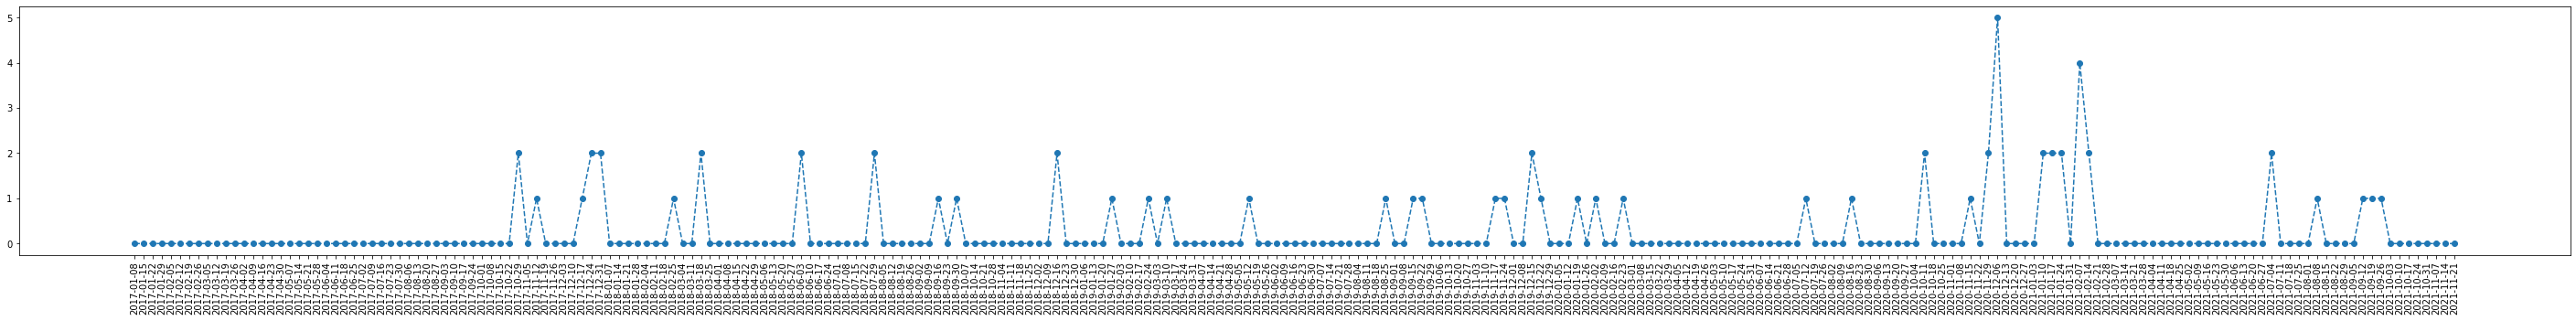

In [9]:
sub_group = get_store_item(df_auxiliar,0,1,12,140)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [10]:
df_auxiliar = reduce_mem_usage(df_auxiliar)

Memory usage of dataframe is 1093.76 MB
Memory usage after optimization is: 427.40 MB
Decreased by 60.9%


# Feature engineering

In [11]:
df_auxiliar['QTT_try_lag5']= df_auxiliar.groupby(['S100','I100','C100','C101'])['QTT'].shift(5)
df_auxiliar['QTT_try_lag6']= df_auxiliar.groupby(['S100','I100','C100','C101'])['QTT'].shift(6)
df_auxiliar['QTT_try_lag7']= df_auxiliar.groupby(['S100','I100','C100','C101'])['QTT'].shift(7)
df_auxiliar['QTT_try_lag8']= df_auxiliar.groupby(['S100','I100','C100','C101'])['QTT'].shift(8)
df_auxiliar['QTT_try_lag9']= df_auxiliar.groupby(['S100','I100','C100','C101'])['QTT'].shift(9)


In [12]:
df_auxiliar.replace([np.inf, -np.inf, np.nan],0,inplace=True)


In [13]:
for col in df_auxiliar.columns:
    if len(df_auxiliar[col].unique()) == 1:
        print('drop unique column',col)
        df_auxiliar.drop(col,inplace=True,axis=1)

In [14]:
del df_sales
del df_submission_sample
gc.collect()

45

In [15]:
df_sales_original             = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_submission_sample_original = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

df_sales_original['DATE']             = pd.to_datetime(df_sales_original['DATE'])
df_submission_sample_original['DATE'] = pd.to_datetime(df_submission_sample_original['DATE'])

In [16]:
df_submission_sample_original['DATE'].min(),df_submission_sample_original['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [17]:
df_auxiliar['DATE'].min(),df_auxiliar['DATE'].max()

(Timestamp('2017-01-08 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [18]:
features_names = set(df_auxiliar.columns)-set(['QTT','item_id','ID'])
print(features_names)

{'C100', 'QTT_try_lag5', 'QTT_try_lag8', 'QTT_try_lag6', 'C101', 'S100', 'QTT_try_lag7', 'DATE', 'QTT_try_lag9', 'I100'}


In [19]:
df_sales_original             = df_sales_original[['DATE','item_id']].merge(df_auxiliar,on=['DATE','item_id'],how='left').copy()
df_submission_sample_original = df_submission_sample_original[['DATE','item_id']].merge(df_auxiliar,on=['DATE','item_id'],how='left').copy()

In [20]:
df_submission_sample_original['DATE'].min(),df_submission_sample_original['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [21]:
df_sales_original = df_sales_original.merge(df_items,on=['I100'],how='left')
df_sales_original = df_sales_original.merge(df_stores,on=['S100'],how='left')

In [22]:
df_submission_sample_original = df_submission_sample_original.merge(df_items,on=['I100'],how='left')
df_submission_sample_original = df_submission_sample_original.merge(df_stores,on=['S100'],how='left')

In [23]:
df_submission_sample_original['DATE']

0       2021-10-03
1       2021-10-03
2       2021-10-03
3       2021-10-03
4       2021-10-03
           ...    
69116   2021-11-21
69117   2021-11-21
69118   2021-11-21
69119   2021-11-21
69120   2021-11-21
Name: DATE, Length: 69121, dtype: datetime64[ns]

In [24]:
df_submission_sample_original['DATE'].min(),df_submission_sample_original['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [25]:
df_sales_original             = fe_dates(df_sales_original)
df_submission_sample_original = fe_dates(df_submission_sample_original)


In [26]:
del df_auxiliar
gc.collect()

0

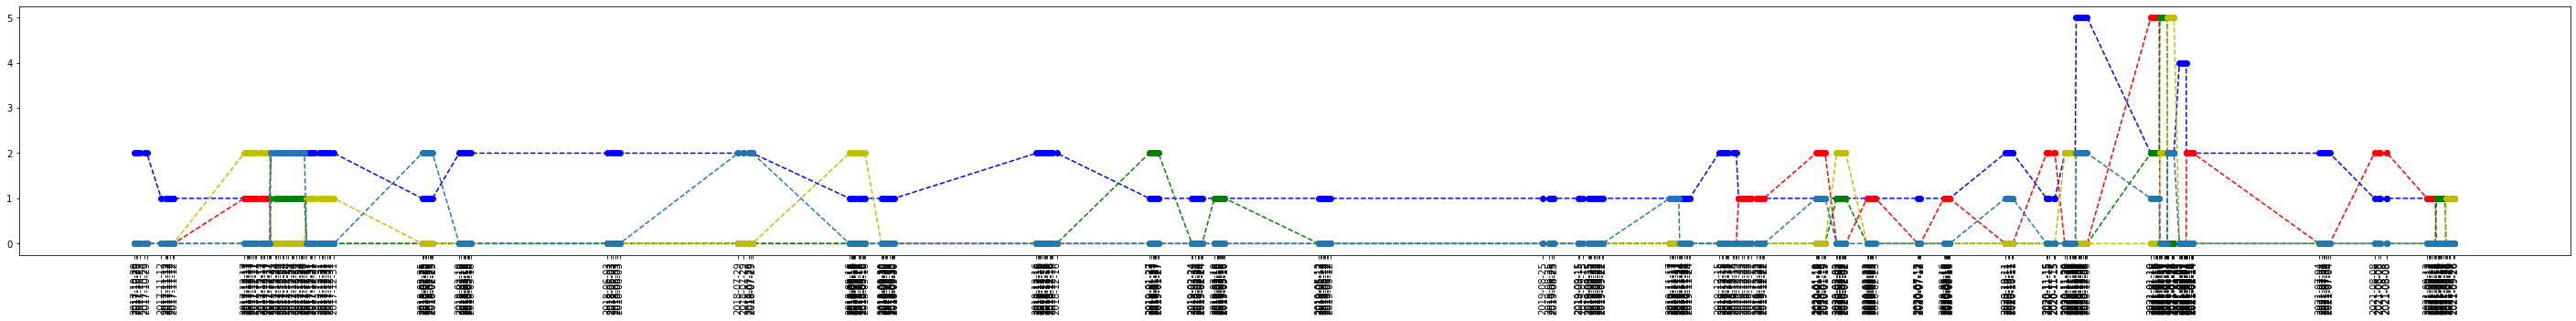

In [27]:
sub_group = get_store_item(df_sales_original,0,1,12,140)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--ob')
plt.plot(sub_group.index,sub_group['QTT_try_lag5'],'--or')
plt.plot(sub_group.index,sub_group['QTT_try_lag6'],'--og')
plt.plot(sub_group.index,sub_group['QTT_try_lag7'],'--oy')
plt.plot(sub_group.index,sub_group['QTT_try_lag8'],'--o')
#plt.legend(["QTT", "QTT_try_lag5"], loc ="upper right")
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [28]:
#df_sales2 = df_sales[df_sales['QTT']<=15].copy()

In [29]:
#df_submission_sample = df_submission_sample[df_submission_sample['S100']==0]

In [30]:
features_names = set(df_sales_original.columns)-set(['QTT','DATE','item_id','ID'])
print(features_names)

{'is_month_end', 'QTT_try_lag5', 'S102', 'S101', 'I101', 'I102', 'day_of_week', 'QTT_try_lag9', 'S103', 'year', 'month', 'C100', 'is_year_start', 'is_quarter_start', 'QTT_try_lag8', 'QTT_try_lag6', 'C101', 'S100', 'QTT_try_lag7', 'day_of_year', 'day', 'is_month_start', 'I103', 'I100'}


In [31]:
from sklearn.model_selection import train_test_split


y_submission = df_submission_sample_original['QTT']
X_submission = df_submission_sample_original[features_names]


if True:
    X_train      = df_sales_original[(df_sales_original['DATE'] >= '2017-01-01') & (df_sales_original['DATE'] < '2021-06-01')].copy()
    X_validation = df_sales_original[(df_sales_original['DATE'] >= '2021-06-01') & (df_sales_original['DATE'] < '2021-08-01')].copy()
    X_test       = df_sales_original[(df_sales_original['DATE'] >= '2021-08-01') & (df_sales_original['DATE'] < '2021-10-03')].copy() 
    
    #X_train = X_train[X_train['QTT']<=350].copy()

    y_train = X_train['QTT']
    X_train = X_train[features_names]

    y_validation = X_validation['QTT']
    X_validation = X_validation[features_names]

    y_test = X_test['QTT']
    X_test = X_test[features_names]

else:
    #X_train      = df_sales[((df_sales['DATE'] >= '2019-01-01') & (df_sales['DATE'] < '2020-01-01'))|
    #                        ((df_sales['DATE'] >= '2021-01-01') & (df_sales['DATE'] < '2021-08-01'))].copy()
    X_train      = df_sales[((df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2021-08-01'))].copy()
    X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] < '2021-10-03')].copy() 

    y_train = X_train['QTT']
    X_train = X_train[features_names]

    y_test = X_test['QTT']
    X_test = X_test[features_names]

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

<AxesSubplot:>

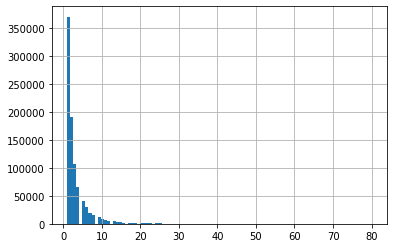

In [32]:
y_validation.hist(bins=100)

<AxesSubplot:>

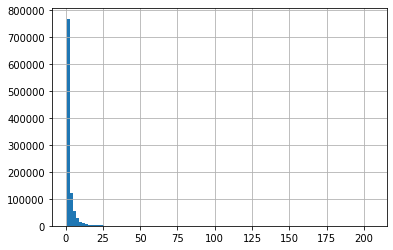

In [33]:
y_test.hist(bins=100)

In [34]:
#X_test[y_test.values>25]['S100'].value_counts()

In [35]:
import lightgbm as lgb

hyper_params = {
    #'device':'gpu',
    'is_unbalance':True,
    'is_enable_sparse':True,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'verbose': 0,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    "max_depth": 8,
    "num_leaves": 30,  
    "max_bin": 128,
    "num_iterations": 8000

}

In [36]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_validation, y_validation)

In [ ]:
gbm = lgb.train(hyper_params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
X_train_pred      = gbm.predict(X_train)#, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm.predict(X_validation)#, num_iteration=gbm.best_iteration_)
X_test_pred       = gbm.predict(X_test)#, num_iteration=gbm.best_iteration_)

X_submission_pred = gbm.predict(X_submission)#, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_error

X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)
X_submission_pred = np.maximum(X_submission_pred, 0)

df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)

In [ ]:
#X_test_pred[0] = 200

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

In [ ]:
filename_submission= 'submission_baseline01_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = False
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)

In [ ]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

In [ ]:
df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [ ]:
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)